In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/train_loan.csv')

# Display the first 5 rows of the DataFrame
display(df.head())

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Task
Preprocess the `df` DataFrame by handling missing values, detecting and treating outliers, encoding categorical variables, and scaling numerical features.

## Missing Value Handling


Identify columns with missing values and decide on an appropriate strategy for imputation. This might involve using the mean, median, or mode for numerical columns, or the mode for categorical columns. Alternatively, rows or columns with a high percentage of missing values might be dropped.


**Reasoning**:
To identify columns with missing values and the count of missing values in each,  use the `.isnull().sum()` method on the DataFrame `df`. This will provide a clear overview of where imputation or dropping might be necessary.



In [2]:
print('Missing values before imputation:')
print(df.isnull().sum())

Missing values before imputation:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64



To understand the nature of each column and decide on appropriate imputation strategies (mean/median for numerical, mode for categorical), inspect the data types of the columns with missing values. After inspecting the data types, I will proceed with the imputation.



In [3]:
print('Data types of columns with missing values:')
print(df[['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']].dtypes)

Data types of columns with missing values:
Gender               object
Married              object
Dependents           object
Self_Employed        object
LoanAmount          float64
Loan_Amount_Term    float64
Credit_History      float64
dtype: object



Based on the identified data types, impute the missing values in categorical columns ('Gender', 'Married', 'Dependents', 'Self_Employed') using their respective modes, as this is a common strategy for categorical data.



In [4]:
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
print('Missing values after categorical imputation:')
print(df[['Gender', 'Married', 'Dependents', 'Self_Employed']].isnull().sum())

Missing values after categorical imputation:
Gender           0
Married          0
Dependents       0
Self_Employed    0
dtype: int64


/tmp/ipython-input-2651702272.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)



The previous code produced a `FutureWarning` due to chained assignment with `inplace=True`. To resolve this and ensure compatibility with future pandas versions,  modify the imputation logic to directly assign the filled column back to the DataFrame.



In [5]:
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)
print('Missing values after categorical imputation:')
print(df[['Gender', 'Married', 'Dependents', 'Self_Employed']].isnull().sum())

Missing values after categorical imputation:
Gender           0
Married          0
Dependents       0
Self_Employed    0
dtype: int64



Now that the categorical missing values are handled, next impute the missing values in the numerical columns ('LoanAmount', 'Loan_Amount_Term', 'Credit_History') using their respective medians, as median imputation is robust to outliers which might be present in numerical data.



In [6]:
for col in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)
print('Missing values after numerical imputation:')
print(df[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']].isnull().sum())

Missing values after numerical imputation:
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64


## Outlier Detection


Detecting outliers in numerical columns using methods such as the Interquartile Range (IQR) method, Z-score, or visualization techniques like box plots. Based on the findings, decide whether to remove, transform, or cap the outliers.



To begin detecting and treating outliers, first identify all numerical columns in the DataFrame `df`. select columns with data types such as 'int64' or 'float64' and store their names in a list called `numerical_cols`.



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

print("Numerical columns identified:")
print(numerical_cols)

Numerical columns identified:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']



To visualize the distribution and potential outliers in each numerical column,  generate box plots for every column in `numerical_cols` using `seaborn` and `matplotlib`.



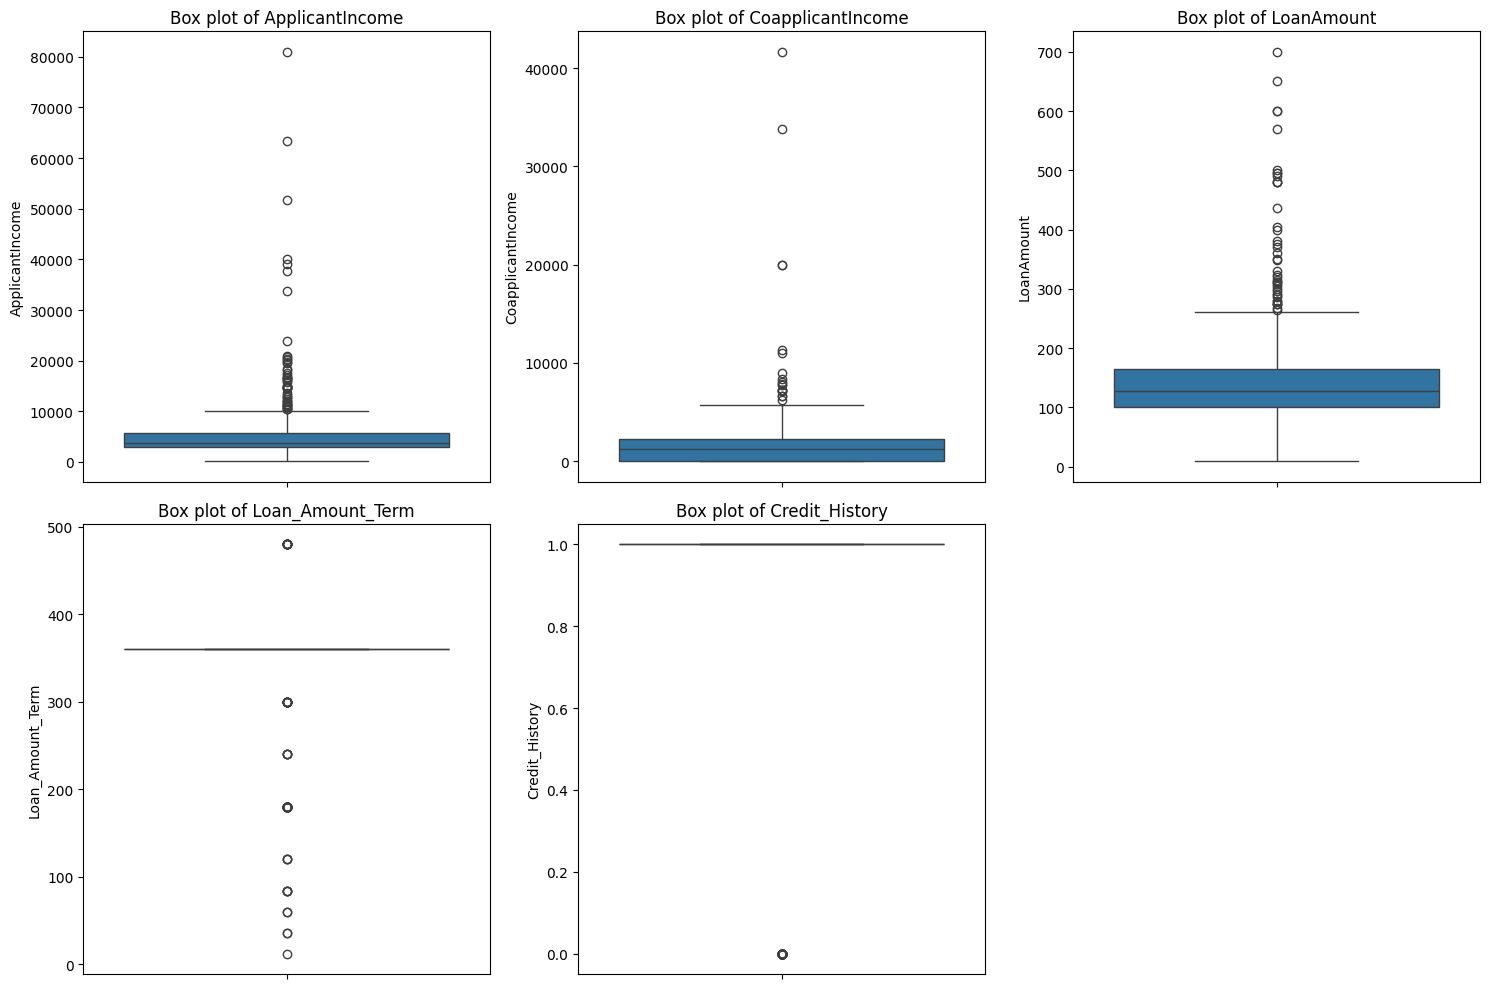

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of columns
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()


Now that the numerical columns are identified and visualized, proceed to calculate the first quartile (Q1), third quartile (Q3), and Interquartile Range (IQR) for each, then define the upper and lower bounds to identify outliers.



In [9]:
print('Outlier Capping Details:')
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before capping
    outliers_before = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    # Cap outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    # Count outliers after capping (should be 0 if capped correctly)
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    print(f"Column: {col}")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Number of outliers capped: {outliers_before}")
    print(f"  Number of outliers remaining after capping: {outliers_after}\n")

Outlier Capping Details:
Column: ApplicantIncome
  Q1: 2877.50, Q3: 5795.00, IQR: 2917.50
  Lower Bound: -1498.75, Upper Bound: 10171.25
  Number of outliers capped: 50
  Number of outliers remaining after capping: 0

Column: CoapplicantIncome
  Q1: 0.00, Q3: 2297.25, IQR: 2297.25
  Lower Bound: -3445.88, Upper Bound: 5743.12
  Number of outliers capped: 18
  Number of outliers remaining after capping: 0

Column: LoanAmount
  Q1: 100.25, Q3: 164.75, IQR: 64.50
  Lower Bound: 3.50, Upper Bound: 261.50
  Number of outliers capped: 41
  Number of outliers remaining after capping: 0

Column: Loan_Amount_Term
  Q1: 360.00, Q3: 360.00, IQR: 0.00
  Lower Bound: 360.00, Upper Bound: 360.00
  Number of outliers capped: 88
  Number of outliers remaining after capping: 0

Column: Credit_History
  Q1: 1.00, Q3: 1.00, IQR: 0.00
  Lower Bound: 1.00, Upper Bound: 1.00
  Number of outliers capped: 89
  Number of outliers remaining after capping: 0



## Encoding Categorical Variables


Convert categorical features into a numerical format. For nominal categorical variables (like 'Gender', 'Married', 'Property_Area'), one-hot encoding will be applied. For ordinal categorical variables (if any), label encoding or a similar ordinal encoding method will be used.



First,  identify all categorical columns in the DataFrame `df` by checking their data types. This will help distinguish them from numerical columns and prepare for encoding.



In [10]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns identified:")
print(categorical_cols)

Categorical columns identified:
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


 encode the 'Loan_Status' column by mapping 'Y' to 1 and 'N' to 0. This is a binary categorical variable, so direct mapping is appropriate.



In [11]:
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
print("Loan_Status column encoded:")
print(df['Loan_Status'].value_counts())

Loan_Status column encoded:
Loan_Status
1    422
0    192
Name: count, dtype: int64



Now that 'Loan_Status' is encoded,  apply one-hot encoding to the remaining nominal categorical columns ('Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area') using `pd.get_dummies()` with `drop_first=True` to prevent multicollinearity. Afterward, concatenate these new columns with the original DataFrame and drop the original categorical columns and 'Loan_ID'



In [12]:
columns_to_encode = [col for col in categorical_cols if col not in ['Loan_ID', 'Loan_Status']]
df_encoded = pd.get_dummies(df[columns_to_encode], drop_first=True)

df = pd.concat([df.drop(columns=columns_to_encode + ['Loan_ID']), df_encoded], axis=1)

print("DataFrame after one-hot encoding and dropping original columns:")
print(df.head())
print("New DataFrame shape:", df.shape)
print("New DataFrame columns:", df.columns.tolist())

DataFrame after one-hot encoding and dropping original columns:
   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0           5849.0                0.0       128.0             360.0   
1           4583.0             1508.0       128.0             360.0   
2           3000.0                0.0        66.0             360.0   
3           2583.0             2358.0       120.0             360.0   
4           6000.0                0.0       141.0             360.0   

   Credit_History  Loan_Status  Gender_Male  Married_Yes  Dependents_1  \
0             1.0            1         True        False         False   
1             1.0            0         True         True          True   
2             1.0            1         True         True         False   
3             1.0            1         True         True         False   
4             1.0            1         True        False         False   

   Dependents_2  Dependents_3+  Education_Not Graduate  Self_Emp

## Scaling Numerical Features

Scale numerical features to standardize their ranges. This will involve using methods like StandardScaler or MinMaxScaler to ensure that all numerical features contribute equally to model training.


To prepare for scaling,  identify all numerical columns that require transformation. These are typically the 'float64' and 'int64' columns that are not binary encoded categorical features or the target variable.



In [13]:
numerical_cols_for_scaling = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Exclude any binary encoded columns that might have slipped through if they were originally categorical.
# In this case, 'Loan_Status' is our target and is already 0/1, so we should exclude it from scaling if it's in numerical_cols_for_scaling.
if 'Loan_Status' in numerical_cols_for_scaling:
    numerical_cols_for_scaling.remove('Loan_Status')

print("Numerical columns identified for scaling:")
print(numerical_cols_for_scaling)

Numerical columns identified for scaling:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


apply `StandardScaler` to the identified numerical columns to standardize their ranges. This is a common practice to ensure that features contribute equally to model training, especially for algorithms sensitive to feature scales.



In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_cols_for_scaling] = scaler.fit_transform(df[numerical_cols_for_scaling])

print("DataFrame after scaling numerical features (first 5 rows):")
print(df.head())

DataFrame after scaling numerical features (first 5 rows):
   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         0.497164          -0.874587   -0.168041               0.0   
1        -0.013767           0.054395   -0.168041               0.0   
2        -0.652632          -0.874587   -1.280462               0.0   
3        -0.820924           0.578025   -0.311579               0.0   
4         0.558104          -0.874587    0.065209               0.0   

   Credit_History  Loan_Status  Gender_Male  Married_Yes  Dependents_1  \
0             0.0            1         True        False         False   
1             0.0            0         True         True          True   
2             0.0            1         True         True         False   
3             0.0            1         True         True         False   
4             0.0            1         True        False         False   

   Dependents_2  Dependents_3+  Education_Not Graduate  Self_Employed

## Summary:

### Data Analysis Key Findings

*   **Missing Value Handling**:
    *   Missing values were initially found in 'Gender' (13), 'Married' (3), 'Dependents' (15), 'Self\_Employed' (32), 'LoanAmount' (22), 'Loan\_Amount\_Term' (14), and 'Credit\_History' (50) columns.
    *   Categorical columns ('Gender', 'Married', 'Dependents', 'Self\_Employed') were imputed using their respective modes.
    *   Numerical columns ('LoanAmount', 'Loan\_Amount\_Term', 'Credit\_History') were imputed using their respective medians.
    *   All missing values were successfully addressed, resulting in zero missing values in these columns.
*   **Outlier Detection and Treatment**:
    *   Outliers were detected in five numerical columns: 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan\_Amount\_Term', and 'Credit\_History'.
    *   The Interquartile Range (IQR) method was used to define outlier bounds (Q1 - 1.5 \* IQR and Q3 + 1.5 \* IQR).
    *   Outliers were capped at these calculated lower and upper bounds.
    *   Specifically, 50 outliers were capped in 'ApplicantIncome', 18 in 'CoapplicantIncome', 41 in 'LoanAmount', 88 in 'Loan\_Amount\_Term', and 89 in 'Credit\_History'. After capping, no outliers remained based on the IQR criteria.
*   **Categorical Variable Encoding**:
    *   The 'Loan\_Status' column was encoded numerically, mapping 'Y' to 1 and 'N' to 0. (422 instances of '1' and 192 instances of '0').
    *   Other nominal categorical columns ('Gender', 'Married', 'Dependents', 'Education', 'Self\_Employed', 'Property\_Area') were one-hot encoded using `pd.get_dummies()` with `drop_first=True`.
    *   The original categorical columns and 'Loan\_ID' were removed, and the new dummy variables were concatenated, resulting in a DataFrame with a shape of (614, 15).
*   **Numerical Feature Scaling**:
    *   Numerical features identified for scaling were 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan\_Amount\_Term', and 'Credit\_History'. The already encoded 'Loan\_Status' was correctly excluded from scaling.
    *   `StandardScaler` was applied to these numerical columns to standardize their ranges.

